### Import Statements

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.layers import Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
import numpy as np

### Variables

In [2]:
batch_size = 64
data_dir = 'data'
img_size = (128, 32)
max_text_len = 32

### Load Data

In [3]:
# Utility function for load data
def truncate_labels(text_to_be_checked, max_text_lenght):
    '''
    Truncate the word lenght such that cost is 32
    if word[i] == word[i-1]
        cost += 2
    if word[i] != word[i-1]
        cost += 1
        
    eg. cost for hello
    h     = 1
    he    = 2
    hel   = 3
    hell  = 5
    hello = 6
    Args:
        text_to_be_checked: string
        max_text_lenght: Maximum text length allowed
    Returns:
        Truncated string
        
    '''
    cost = 0
    for i in range(len(text_to_be_checked)):
        if text_to_be_checked[i] == text_to_be_checked[i-1] and i != 0:
            cost += 2
        else:
            cost += 1
        if cost > max_text_lenght:
            return text_to_be_checked[:i]
    return text_to_be_checked

In [4]:
# load the data
# Contains collection of all characters 
collection_of_characters = set()

# All image paths
all_image_paths = []

# All labels
all_labels = []

# known broken images in IAM dataset
bad_samples_reference = ['a01-117-05-02', 'r06-022-03-05']


f = open(data_dir + '/gt/words.txt')
for i, line in enumerate(f):
#     print('Processing: {}                       '.format(i+1), end = '\r')
    if not line or line[0] == '#':
        continue
    line_components = line.strip().split(' ')
    assert len(line_components) >= 9

    file_name_components = line_components[0].split('-')
    file_path = os.path.join(data_dir, 'img', file_name_components[0], file_name_components[0]+'-'+file_name_components[1], line_components[0]+'.png')

    if line_components[0] in bad_samples_reference:
        continue

    truncated_text = truncate_labels(' '.join(line_components[8:]), max_text_len)
    collection_of_characters = collection_of_characters.union(set(list(truncated_text)))
    
    all_image_paths.append(file_path)
    all_labels.append(truncated_text)
    
# list of all characters
char_list = sorted(list(collection_of_characters))

# Split into train and test
split = int(0.95 * len(all_image_paths))

train_image_paths = all_image_paths[:split]
train_labels = all_labels[:split]

test_image_paths = all_image_paths[split:]
test_labels = all_labels[split:]

In [5]:
# Charater to number and number to character obj
char_to_num = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=char_list, num_oov_indices=0)
num_to_char = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True, oov_token = '')

In [6]:
def process_element(file_path, label):
    '''
    The function used in input data pipelines.
    Can only contain tensorflow operations
    Args:
        file_path: Image file path (string)
        label: Label string
    Returns:
        img: An image tensor of
        label_length: The lenght of label string
        y_true: padded label
    '''
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize_with_pad(img, img_size[1], img_size[0])
    img = tf.transpose(img, perm = [1,0,2])
    img = img / 255
    label_num = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    label_length = tf.shape(label_num)
    # 21 refers to max string length
    y_true = tf.pad(label_num, [[0,21-label_length[0]]], mode='CONSTANT', constant_values=0)
    return img, label_length, y_true


def augment(img):
    ## ADD AUGMENTATIONS HERE ##
    return img

def wrapper_augment(image, label_length, y_true):
    image = tf.py_function(augment, [image], "float32")
    return {"image":image, "label_length":label_length, "y_true":y_true}

In [7]:
# Create Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels)).shuffle(len(train_labels)).map(process_element, num_parallel_calls = tf.data.experimental.AUTOTUNE).map(wrapper_augment, num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(batch_size)

val_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels)).shuffle(len(test_labels)).map(process_element, num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(batch_size)

(16, 128, 32, 1)
(16, 21)
(16, 1)


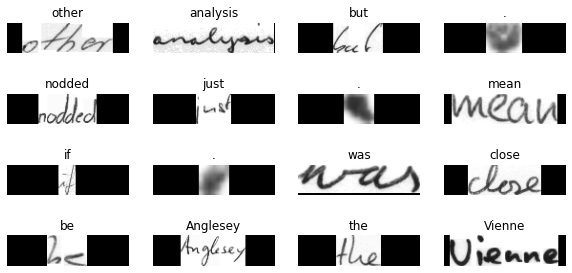

In [8]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_ds.take(1):
    images = batch["image"][:16]
    labels = batch["y_true"][:16]
    label_lengths = batch['label_length'][:16]
    print(images.shape)
    print(labels.shape)
    print(label_lengths.shape)
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

### CTC Loss

In [ ]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self,name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, label_length, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        label_length = tf.cast(label_length, dtype="int64")
        
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

### Model

In [ ]:
def build_model():
    input_shape = (128, 32, 1)     

    input_image = Input(name='image', shape=input_shape, dtype='float32')
    input_y_true = Input(name="y_true", shape=(21,))
    input_label_length = Input(name="label_length", shape=(1,))

    x = Conv2D(32, (5, 5), padding='same', name='conv_1', kernel_initializer='he_normal')(input_image) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='max_pool_1')(x)

    x = Conv2D(64, (5, 5), padding='same', name='conv_2', kernel_initializer='he_normal')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='max_pool_2')(x)

    x = Conv2D(128, (3, 3), padding='same', name='conv_3', kernel_initializer='he_normal')(x)  
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(1, 2), name='max_pool_3')(x)  
    
    x = Conv2D(128, (3, 3), padding='same', name='conv_4', kernel_initializer='he_normal')(x)  
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(1, 2), name='max_pool_4')(x)  

    x = Conv2D(256, (3, 3), padding='same', name='conv_5', kernel_initializer='he_normal')(x)  
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(1, 2), name='max_pool_5')(x)  

    x = Reshape(target_shape=((32, 256)), name='reshape')(x)  
    x = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_1')(x)  
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
    
    x = Dense(len(char_to_num.get_vocabulary()) + 1, kernel_initializer='he_normal',name='dense_2')(x) 
    x = Activation('softmax', name='softmax')(x)
    
    output = CTCLayer(name = "ctc_loss")(input_y_true, input_label_length, x)
    
    model = tf.keras.models.Model(
        inputs=[input_image, input_y_true, input_label_length], outputs=output, name="ocr_model"
    )
    model.compile(optimizer=tf.keras.optimizers.Adam())
    return model
model = build_model()
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True)

### Training

In [ ]:
# Callbacks
# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping],
)

### Extract the model for prediction

In [ ]:
prediction_model = tf.keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="softmax").output
)
prediction_model.summary()

### Saving the model

In [9]:
# prediction_model.save('ocr_model_v1.h5')
prediction_model_loaded = tf.keras.models.load_model('ocr_model_v1.h5')

### Decoding the predictions

In [10]:
def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1] 
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=False)[0][0][:, :21]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


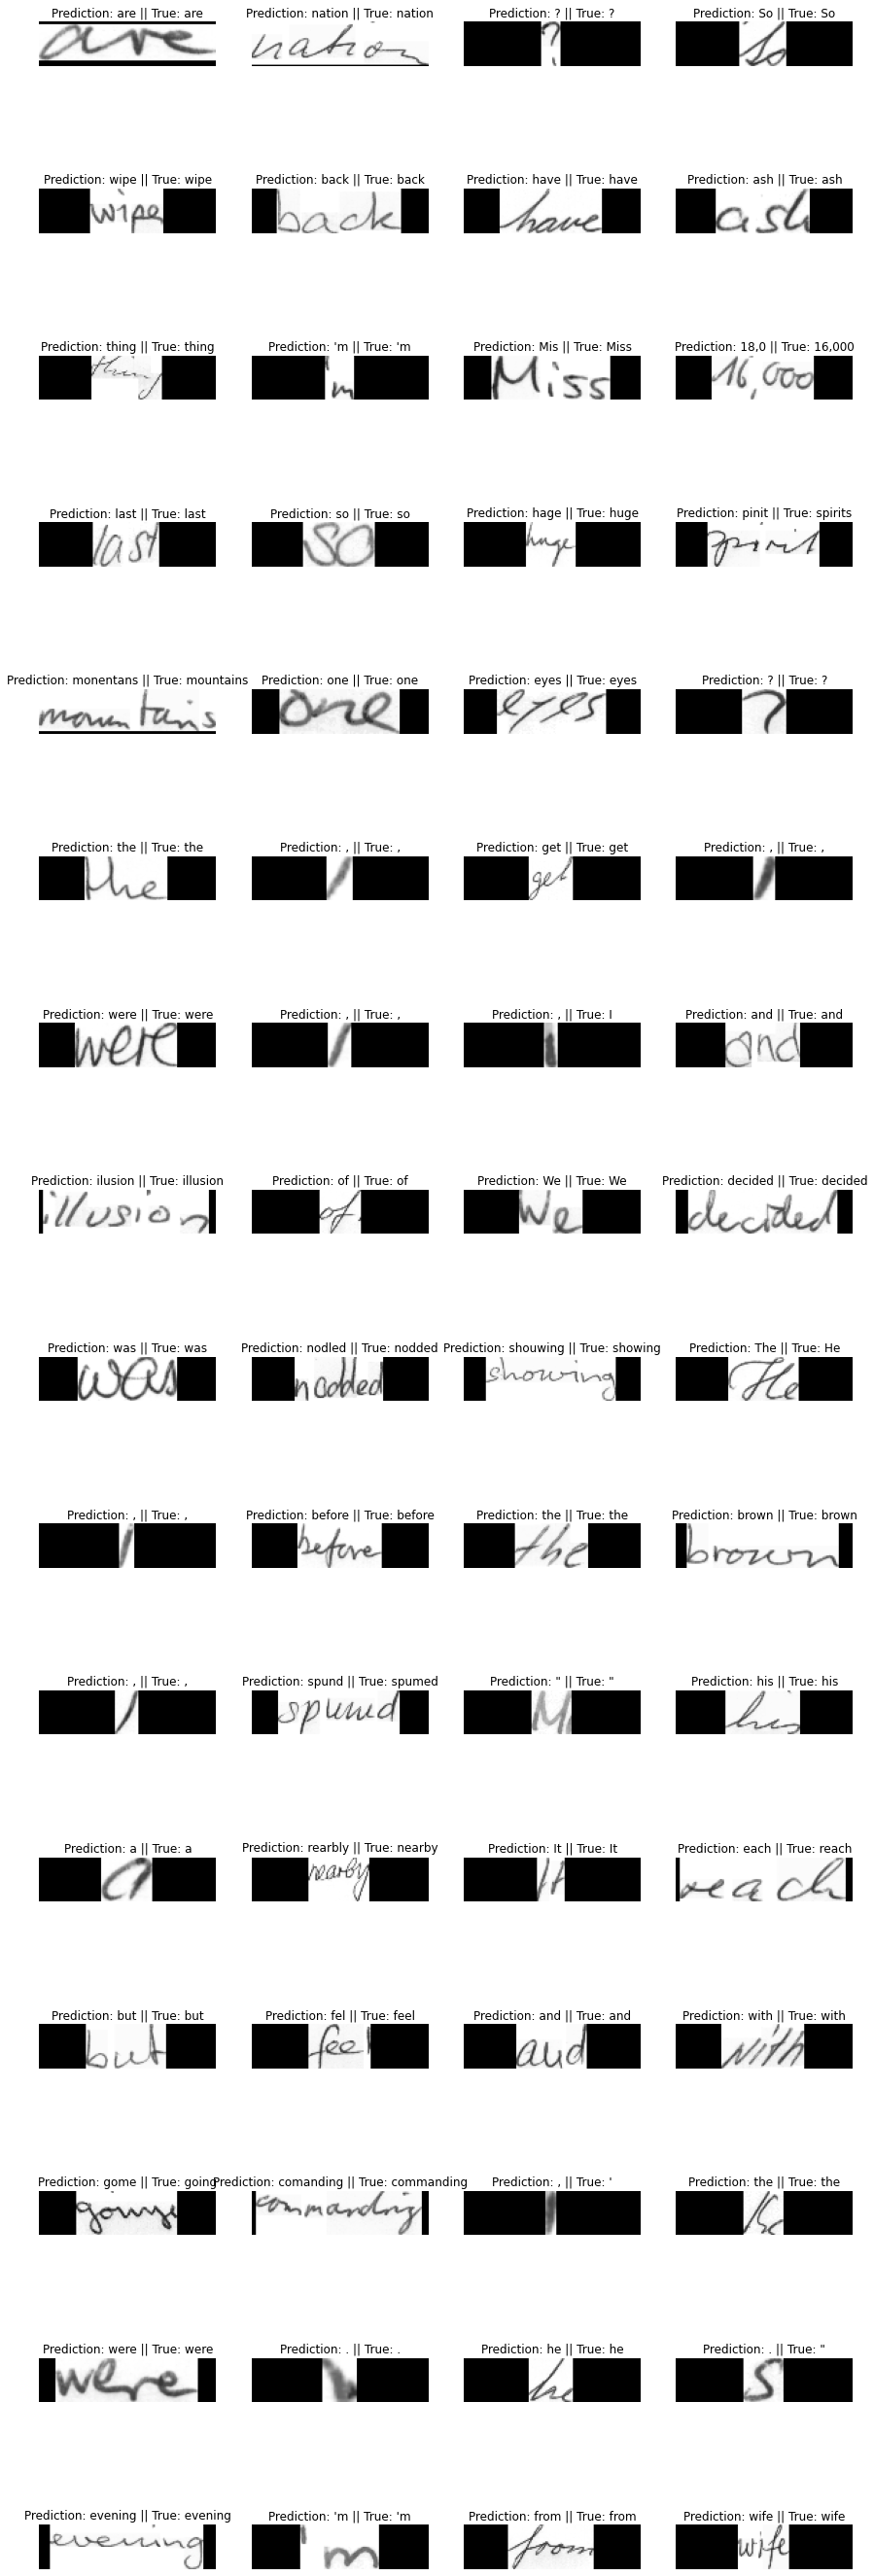

In [11]:
for batch in val_ds.take(1):
    batch_images = batch[0][:64]
    batch_labels = batch[2][:64]
    batch_label_lenght = batch[1][:64]

    preds = prediction_model_loaded.predict(batch_images)
    pred_texts = decode_predictions(preds)

    orig_texts = []
    for i,label in enumerate(batch_labels):
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(16, 4, figsize=(15, 50))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]} || True: {orig_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()